In [18]:
import pdb

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # 假设使用线性回归作为预测模型
%load_ext autoreload
%autoreload 2
from script.temp.tools.data_utils import data_utils
data = data_utils('config.xlsx','result.xlsx')
data.preprocess()
print(len(data.df_result))
data.df_result = data.drop(['IOPS_Read', 'IOPS_Write', 'Bandwidth_Read', 'Bandwidth_Write'],0)
print(len(data.df_result))
data.targetLst = ['IOPS_Read']
X,y = data.dorp_and_encode()
X = X.drop(columns=['IOPS_Write', 'Bandwidth_Read', 'Bandwidth_Write'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
6627
6566


In [3]:
from script.temp.tools.GA import features_MI
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# 示例数据
X,y = data.dorp_and_encode()
scaler = MinMaxScaler()
X = X.values.astype(float)
y = y.values.astype(float)
X_scaled = scaler.fit_transform(X)
#y_scaled = y.reshape(-1, 1)/10000
y_scaled = scaler.fit_transform(y)
y_scaled = y_scaled.squeeze()
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
selected_features = features_MI(X_train,y_train)
y

array([[3.54152e+04],
       [8.97000e+01],
       [4.98500e+02],
       ...,
       [6.34430e+03],
       [8.88907e+04],
       [9.62543e+04]])

In [61]:
from script.temp.tools.model import evaluate
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import numpy as np
from sklearn.svm import SVR
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from script.temp.tools.data_utils import ExtraRandomForest
# 计算误差
#X_train_selected X_test_selected y_train y_test
# 根据选择的特征重新训练决策树模型
#num = X.shape[0]
num =2000
X_train_selected = X_train[5000-num:-1, selected_features]
y_train_selected = y_train[5000-num:-1]
X_test_selected = X_test[:, selected_features]
X_train_selected = X_train[5000-num:-1, :]
y_train_selected = y_train[5000-num:-1]
X_test_selected = X_test[:, :]
model = ExtraTreesRegressor(n_estimators=100,max_features=None )
model.fit(X_train_selected, y_train_selected)

# 使用测试集进行预测
y_pred = model.predict(X_test_selected)

# 在此之后，你可以使用各种评估指标来评估模型的性能
train_error = np.mean(np.abs(y_train_selected - model.predict(X_train_selected)) / y_train_selected) * 100
test_error = np.mean(np.abs(y_test - y_pred) / y_test) * 100

# 打印误差和选择的特征
evaluate(y_pred,y_test,"测试集",True)
df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
df
#print("选择的特征索引:", selected_features)
#X_train_selected

测试集均方误差 (MSE): 0.0006
测试集百分比误差 (Mean Percentage Error): inf%
测试集R2值: 0.7554
测试集平均绝对误差 (MAE): 0.0036


/var/folders/rd/h7txkcl151v0t98vbxrrxz8m0000gn/T/ipykernel_62522/2344572586.py:26: RuntimeWarning: divide by zero encountered in true_divide
  test_error = np.mean(np.abs(y_test - y_pred) / y_test) * 100
/Users/ezra/worksapce/MQSim/script/temp/tools/model.py:6: RuntimeWarning: divide by zero encountered in true_divide
  percentage_error = np.abs((y_true - y_pred) / y_true) * 100


,y_pred,y_test
0,0.003572,0.003537
1,0.001630,0.001196
2,0.028961,0.024904
3,0.000636,0.000637
4,0.000837,0.000846
...,...,...
1309,0.001707,0.001722
1310,0.227734,0.310794
1311,0.000809,0.000804
1312,0.005944,0.005311


In [62]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 将数据转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train_selected, label=y_train_selected)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

# 定义参数
params = {
    'objective': 'reg:squarederror',  # 设置损失函数为均方误差
    'eval_metric': 'rmse'  # 评估指标采用 RMSE
}

# 训练模型
model = xgb.train(params, dtrain, num_boost_round=100)

# 预测
y_pred = model.predict(dtest)
evaluate(y_pred=y_pred,y_true=y_test,p = True)

均方误差 (MSE): 0.0006
百分比误差 (Mean Percentage Error): inf%
R2值: 0.7606
平均绝对误差 (MAE): 0.0044


/Users/ezra/worksapce/MQSim/script/temp/tools/model.py:6: RuntimeWarning: divide by zero encountered in true_divide
  percentage_error = np.abs((y_true - y_pred) / y_true) * 100


(0.0005521766597912235, inf, 0.7605577174986402, 0.004431957066942856)

In [860]:
X_train_selected.shape

(3251, 103)

In [63]:
from script.temp.tools.data_utils import MLP, MPERegressionLoss
from script.tools.collection import CustomDataset

X_train_selected_tensor = torch.tensor(X_train_selected,dtype=torch.float32)
X_test_selected_tensor = torch.tensor(X_test_selected,dtype=torch.float32)
y_train_selected_tensor = torch.tensor(y_train_selected,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test,dtype=torch.float32)
# 参数设置
input_size = X_train_selected_tensor.shape[1]
output_size = 1

# 初始化模型
model = MLP([input_size,40,20,20,10,5, output_size])

# 定义损失函数
criterion_MPE = MPERegressionLoss()
criterion = nn.MSELoss()
# 定义优化器

#X_train_selected_tensor.shape,X_test_selected_tensor.shape,y_train_selected_tensor.shape,y_test_tensor.shape


In [68]:
train_dataset = TensorDataset(X_train_selected_tensor, y_train_selected_tensor)
batch_size = 100
num_epoch = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
for epoch  in range(num_epoch):
    for batch_x,batch_y in  train_loader:
        output = model(batch_x)
        loss = criterion(output.squeeze(),batch_y.squeeze())
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')
y_pred = model(X_test_selected_tensor)

Epoch [1/100], Loss: 0.0030
Epoch [2/100], Loss: 0.0004
Epoch [3/100], Loss: 0.0034
Epoch [4/100], Loss: 0.0007
Epoch [5/100], Loss: 0.0004
Epoch [6/100], Loss: 0.0007
Epoch [7/100], Loss: 0.0009
Epoch [8/100], Loss: 0.0005
Epoch [9/100], Loss: 0.0007
Epoch [10/100], Loss: 0.0011
Epoch [11/100], Loss: 0.0004
Epoch [12/100], Loss: 0.0032
Epoch [13/100], Loss: 0.0006
Epoch [14/100], Loss: 0.0004
Epoch [15/100], Loss: 0.0006
Epoch [16/100], Loss: 0.0005
Epoch [17/100], Loss: 0.0006
Epoch [18/100], Loss: 0.0012
Epoch [19/100], Loss: 0.0021
Epoch [20/100], Loss: 0.0007
Epoch [21/100], Loss: 0.0004
Epoch [22/100], Loss: 0.0004
Epoch [23/100], Loss: 0.0011
Epoch [24/100], Loss: 0.0087
Epoch [25/100], Loss: 0.0017
Epoch [26/100], Loss: 0.0006
Epoch [27/100], Loss: 0.0007
Epoch [28/100], Loss: 0.0011
Epoch [29/100], Loss: 0.0003
Epoch [30/100], Loss: 0.0012
Epoch [31/100], Loss: 0.0006
Epoch [32/100], Loss: 0.0006
Epoch [33/100], Loss: 0.0017
Epoch [34/100], Loss: 0.0003
Epoch [35/100], Loss: 0

In [69]:
evaluate(y_true=y_test_tensor.detach().numpy(),y_pred=y_pred.detach().numpy(),str=" ",p=True)

 均方误差 (MSE): 0.0022
 百分比误差 (Mean Percentage Error): inf%
 R2值: 0.0639
 平均绝对误差 (MAE): 0.0204


/Users/ezra/worksapce/MQSim/script/temp/tools/model.py:6: RuntimeWarning: divide by zero encountered in true_divide
  percentage_error = np.abs((y_true - y_pred) / y_true) * 100


(0.002158686, inf, 0.06392146492178485, 0.020446964)

torch.Tensor

In [454]:
with torch.no_grad():
    #y_pred = model(X_test_selected_tensor)
    #test_loss = criterion_MPE(y_pred.squeeze(),y_test_tensor)
    y_pred = model(X_train_selected_tensor)
    test_loss = criterion_MPE(y_pred.squeeze(),y_train_tensor)
    print(f'Train Loss: {test_loss.item():.4f}')

Train Loss: 0.4611


In [381]:
i = 56
y_pred = model(X_test_selected_tensor)
y_pred.detach()[i],y_test_tensor[i]

percentage_errors = torch.abs((y_test_tensor - y_pred.detach().squeeze()) / y_test_tensor) * 100
mean_percentage_error = torch.mean(percentage_errors).item()
print("Mean Percentage Error (MPE):", mean_percentage_error)
#y_pred.squeeze().shape,y_train_tensor.shape

Mean Percentage Error (MPE): 367.4104309082031


In [4]:
from sklearn.feature_selection import mutual_info_regression

# 计算特征与目标变量之间的互信息
mi_scores = mutual_info_regression(X_train, y_train)
data.X.columns
selected_features = np.ones(103).astype(bool)
n = 0
for i, score in enumerate(mi_scores):
    if score==0:
        #print(f"Feature {i}: {score}")
        selected_features[i] = False
        n = n + 1
        continue
selected_features

Feature 3: 0.0
Feature 5: 0.0
Feature 8: 0.0
Feature 9: 0.0
Feature 10: 0.0
Feature 12: 0.0
Feature 13: 0.0
Feature 17: 0.0
Feature 18: 0.0
Feature 21: 0.0
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.0
Feature 27: 0.0
Feature 29: 0.0
Feature 32: 0.0
Feature 33: 0.0
Feature 34: 0.0
Feature 37: 0.0
Feature 43: 0.0
Feature 49: 0.0
Feature 61: 0.0
Feature 62: 0.0
Feature 68: 0.0
Feature 71: 0.0
Feature 72: 0.0
Feature 73: 0.0
Feature 74: 0.0
Feature 75: 0.0
Feature 76: 0.0
Feature 79: 0.0
Feature 81: 0.0
Feature 82: 0.0
Feature 87: 0.0
Feature 95: 0.0
Feature 96: 0.0
Feature 97: 0.0
Feature 99: 0.0
Feature 100: 0.0


array([ True,  True,  True, False,  True, False,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
       False,  True, False,  True,  True, False, False, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
       False, False,  True,  True])

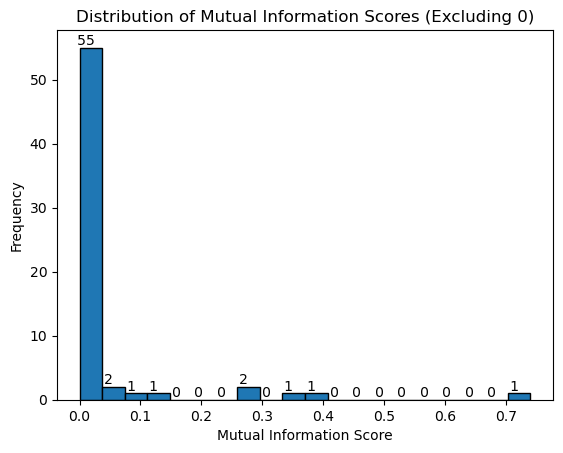

In [56]:
import matplotlib.pyplot as plt

# 过滤值为0的元素
filtered_mi_scores = [score for score in mi_scores if score != 0]

# 绘制分布直方图
counts, bins, _ = plt.hist(filtered_mi_scores, bins=20, edgecolor='black')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mutual Information Scores (Excluding 0)')

# 标记频率
for count, bin in zip(counts, bins):
    plt.text(bin, count, "   "+str(int(count)), ha='center', va='bottom')
plt.show()


In [359]:
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred.squeeze().detach().numpy()
percentage_errors_np = percentage_errors.squeeze().numpy()


y_test_np.shape,y_pred_np.shape,percentage_errors_np.shape
# 创建 DataFrame
df = pd.DataFrame({
    'True Values': y_test_np,
    'Predicted Values': y_pred_np,
    'Percentage Errors': percentage_errors_np
})
df

,True Values,Predicted Values,Percentage Errors
0,0.12423,0.159065,28.040958
1,0.03319,0.094341,184.246353
2,0.28289,3.419613,1108.813721
3,0.08109,0.034114,57.930733
4,7.24398,5.179161,28.503927
...,...,...,...
261,0.02133,0.081731,283.175140
262,0.51265,2.641482,415.260315
263,0.09746,0.961221,886.272705
264,4.20977,3.850405,8.536457


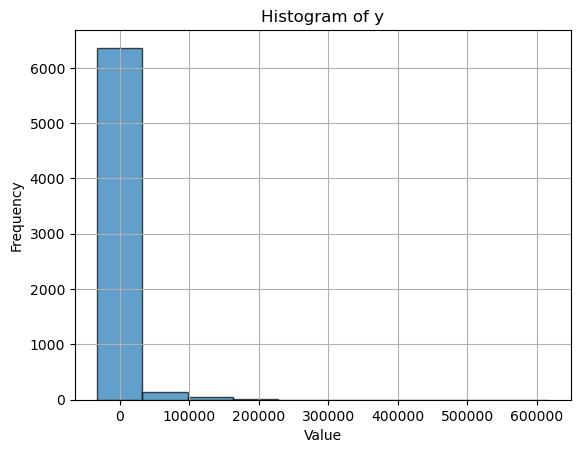

In [827]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = 10
hist, bins = np.histogram(y, bins=num_bins)

# 绘制直方图
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of y')
plt.grid(True)
plt.show()

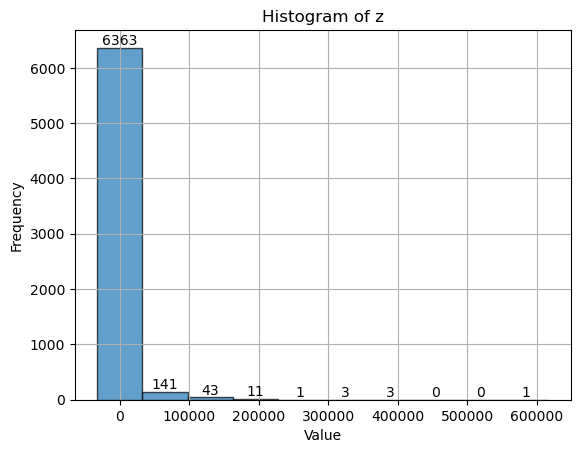

In [830]:
import numpy as np
import matplotlib.pyplot as plt

# 生成随机数据，假设z是一维的numpy数组
z = y

# 将z分成10个区间
num_bins = 10
hist, bins = np.histogram(z, bins=num_bins)

# 绘制直方图
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of z')
plt.grid(True)

# 在每个条形的顶部添加文本标签
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(hist[i]), ha='center', va='bottom')

plt.show()


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from script.temp.tools.model import evaluate
errLst =[]
num =2000
X_train_selected = X_train[5000-num:-1, selected_features]
y_train_selected = y_train[5000-num:-1]
X_test_selected = X_test[:, selected_features]
X_train_selected = X_train[5000-num:-1, :]
y_train_selected = y_train[5000-num:-1]
X_test_selected = X_test[:, :]
# 实例化各个模型
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVM": SVR(),
    "Logistic Regression": LinearRegression()
}
for name, model in models.items():
    model.fit(X_train_selected, y_train_selected)
    y_pred = model.predict(X_test_selected)
    mse,mean_percentage_error,r2,mae = evaluate(y_pred,y_test,name,True)
    errLst.append((mse,mean_percentage_error,r2,mae))

Decision Tree均方误差 (MSE): 0.0007
Decision TreeR2值: 0.7060
Decision Tree平均绝对误差 (MAE): 0.0056
Random Forest均方误差 (MSE): 0.0006
Random ForestR2值: 0.7383
Random Forest平均绝对误差 (MAE): 0.0038
Gradient Boosting均方误差 (MSE): 0.0004
Gradient BoostingR2值: 0.8129
Gradient Boosting平均绝对误差 (MAE): 0.0040
SVM均方误差 (MSE): 0.0057
SVMR2值: -1.4699
SVM平均绝对误差 (MAE): 0.0687
Logistic Regression均方误差 (MSE): 0.0016
Logistic RegressionR2值: 0.3215
Logistic Regression平均绝对误差 (MAE): 0.0176


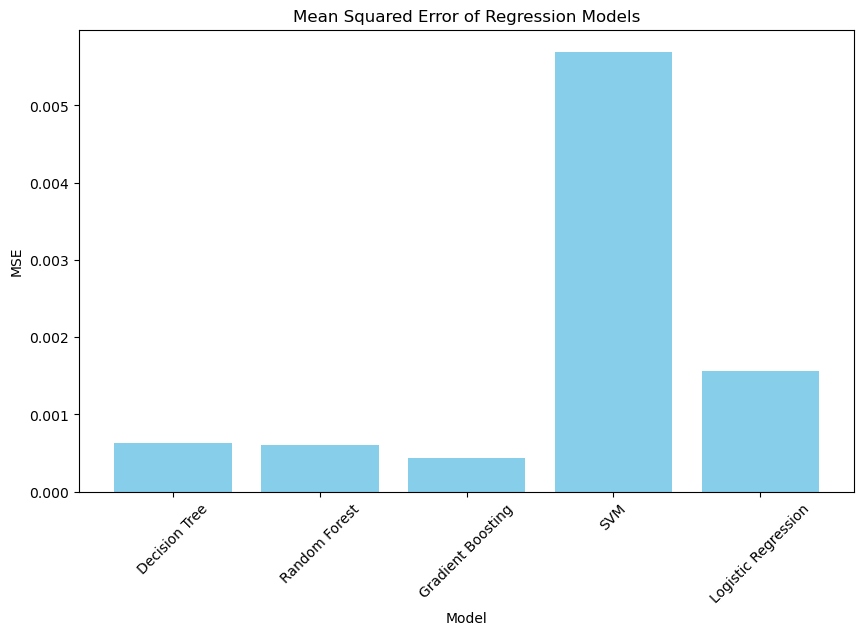

In [11]:
import matplotlib.pyplot as plt

# 训练并评估模型
mse_scores = []
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVM": SVR(),
    "Logistic Regression": LinearRegression()
}

for name, model in models.items():
    model.fit(X_train_selected, y_train_selected)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), mse_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Mean Squared Error of Regression Models')
plt.xticks(rotation=45)
plt.show()


In [20]:
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import random

# 选择不同数量的样本
sample_sizes = [500, 1500, 2000]

r2_scores = []
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVM": SVR(),
    "Logistic Regression": LinearRegression(),
    "Extra Trees": ExtraTreesRegressor(),
    "MLP": MLPRegressor()
}
for size in sample_sizes:
    # 从训练集中随机选择样本
    random_indices = random.sample(range(len(X_train_selected)), size)
    X_train_sampled = X_train_selected[random_indices]
    y_train_sampled = y_train_selected[random_indices]

    r2_scores_for_size = []
    for name, model in models.items():
        model.fit(X_train_sampled, y_train_sampled)
        y_pred = model.predict(X_test_selected)
        r2 = r2_score(y_test, y_pred)
        r2_scores_for_size.append(r2)
    r2_scores.append(r2_scores_for_size)


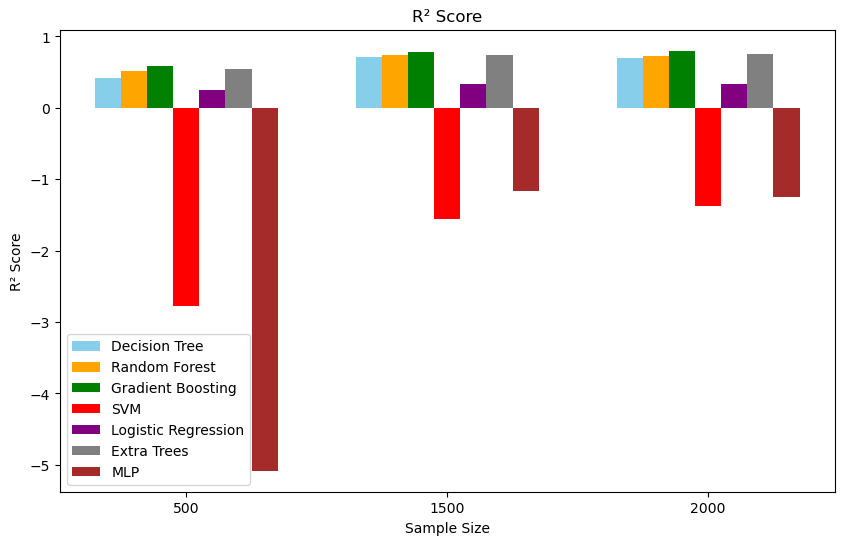

In [26]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# 更新模型列表
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVM": SVR(),
    "Logistic Regression": LinearRegression(),
    "Extra Trees": ExtraTreesRegressor(),
    "MLP": MLPRegressor()
}

# 选择不同数量的样本
sample_sizes = [500, 1500, 2000]

r2_scores = []

for size in sample_sizes:
    # 从训练集中随机选择样本
    random_indices = random.sample(range(len(X_train_selected)), size)
    X_train_sampled = X_train_selected[random_indices]
    y_train_sampled = y_train_selected[random_indices]

    r2_scores_for_size = []
    for name, model in models.items():
        model.fit(X_train_sampled, y_train_sampled)
        y_pred = model.predict(X_test_selected)
        r2 = r2_score(y_test, y_pred)
        r2_scores_for_size.append(r2)
    r2_scores.append(r2_scores_for_size)

# 绘制柱状图
plt.figure(figsize=(10, 6))

bar_width = 0.1
index = range(len(sample_sizes))
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'gray', 'brown']

for i, model_name in enumerate(models.keys()):
    plt.bar([x + i * bar_width for x in index], [r2[i] for r2 in r2_scores], bar_width, label=model_name, color=colors[i])

plt.xlabel('Sample Size')
plt.ylabel('R² Score')
plt.title('R² Score')
plt.xticks([x + 3 * bar_width for x in index], sample_sizes)
plt.legend()
plt.show()
